In [13]:
import numpy as np
import random
import os
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

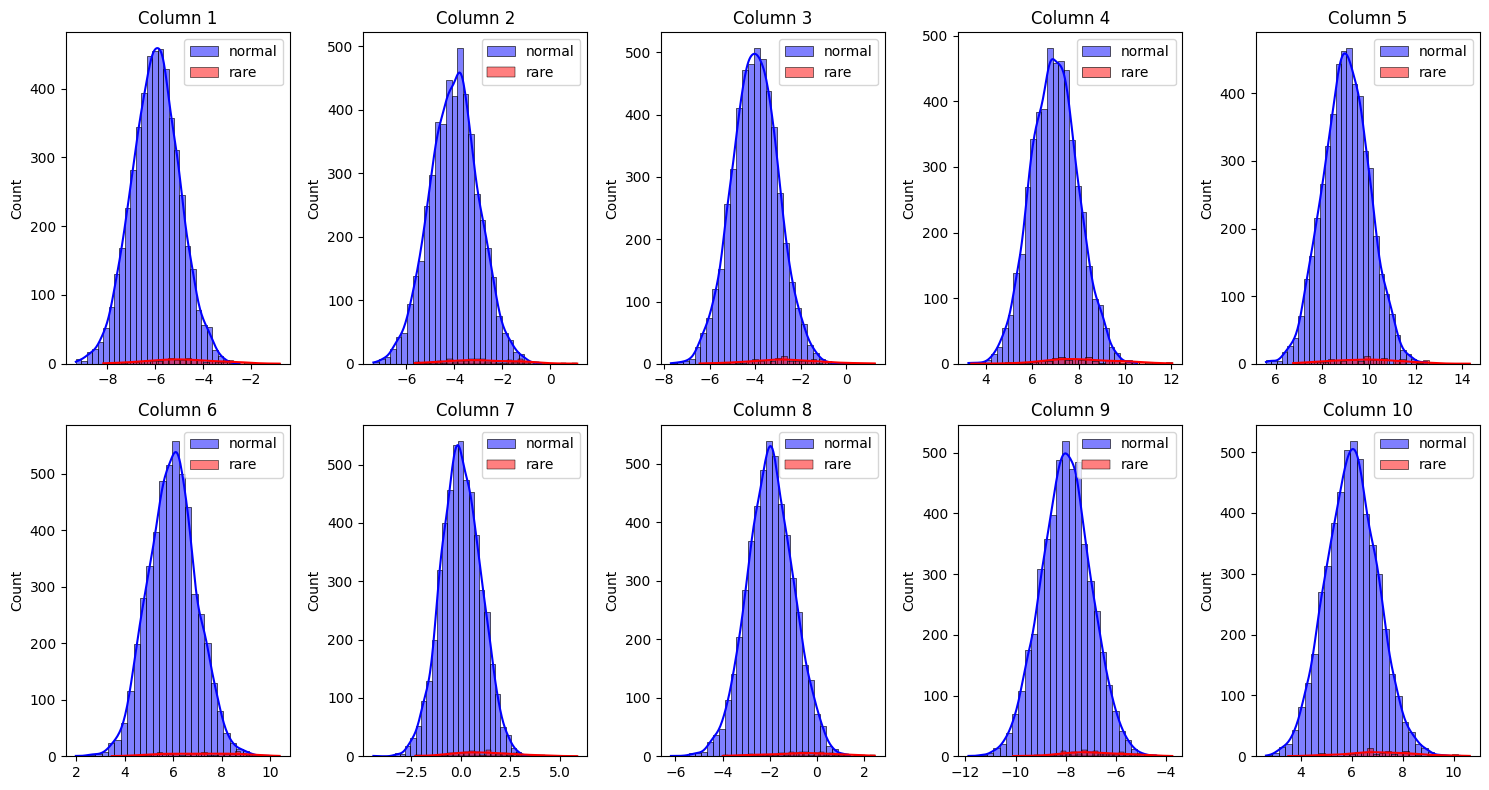

5000
100
5100


In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_size = 5000
np.random.seed(64)

# Generate a random integer array 'a' with shape (10, 1)
a = np.random.randint(-10, 10, size=(10, 1))
mean = a.flatten()

# Generate multivariate normal data 'b' with shape (5000, 10)
b = np.random.multivariate_normal(mean=mean, cov=np.eye(10), size=data_size)

# Generate rare data 'b_rare' with a different covariance matrix
cov_rare = np.eye(10) * (1.5+np.random.randn())  # Adjust the covariance matrix for rare data
b_rare = np.random.multivariate_normal(mean=mean+np.random.randn(), cov=cov_rare, size=100)

b_whole = np.concatenate([b, b_rare], axis=0)

fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

# Loop through each column of 'b' and plot its histogram on the corresponding subplot
for i in range(10):
    sns.histplot(b[:, i], kde=True, bins=30, ax=axes[i], label='normal', color='blue')
    sns.histplot(b_rare[:, i], kde=True, bins=30, ax=axes[i], color='red', label='rare')
    axes[i].set_title(f'Column {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()

print(b.shape[0])
print(b_rare.shape[0])
print(b_whole.shape[0])


In [15]:
labels_1 = np.ones(b.shape[0])
labels_0 = np.zeros(b_rare.shape[0])
labels = np.concatenate([labels_1, labels_0], axis=0)
print(labels.shape)
b_label = np.concatenate([b_whole, labels.reshape(-1, 1)], axis=1)
np.random.shuffle(b_label)
b_label.shape

(5100,)


(5100, 11)

In [16]:
b_label

array([[-5.81003101, -5.51625878, -4.96272597, ..., -7.98277959,
         7.17791446,  1.        ],
       [-7.78093572, -2.3556708 , -4.2928265 , ..., -7.0242091 ,
         4.79261587,  1.        ],
       [-6.70538637, -2.03036273, -2.4679754 , ..., -7.96700662,
         5.54497465,  1.        ],
       ...,
       [-9.10785786, -4.32464595, -3.07542352, ..., -9.94084847,
         5.38586794,  1.        ],
       [-4.47484312, -4.5062016 , -4.93144996, ..., -9.55303019,
         6.65723729,  1.        ],
       [-6.00720408, -4.62558865, -4.10782816, ..., -7.4251385 ,
         6.13393439,  1.        ]])

In [17]:
batch_size = 64
indices = np.random.permutation(b_label.shape[0])
train_indices = indices[:3000]
val_indices = indices[3000:4000]
test_indices = indices[4000:5100]

X_train_5 = np.array(b_label[train_indices, :], dtype=np.float32)
X_val_5 = np.array(b_label[val_indices, :], dtype=np.float32)
X_test_5 = np.array(b_label[test_indices, :], dtype=np.float32)

# sc = StandardScaler()
# sca_X_train_5 = sc.fit_transform(X_train_5)
# sca_X_val_5 = sc.fit_transform(X_val_5)
# sca_X_test_5 = sc.fit_transform(X_test_5)

sca_traindata_loader_5 = DataLoader(X_train_5, batch_size=batch_size, shuffle=True)
sca_valdata_loader_5 = DataLoader(X_val_5, batch_size=batch_size, shuffle=True)
sca_test_loader_5 = DataLoader(X_test_5, batch_size=batch_size, shuffle=True)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义判别器
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # 输出0到1之间的概率值
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [19]:
def train_discriminator(model,optimizer,num_epochs,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            b_input = batch[:,:-1]
            b_input = b_input.cuda()
            b_label = batch[:,-1].float().reshape(-1,1).cuda()
            output = model(b_input)
            loss = criterion(output, b_label)
            whole_loss+=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                batch = val_batch.cuda()
                b_input = val_batch[:,:-1].cuda()
                b_label = val_batch[:,-1].reshape(-1,1).cuda()
                output = model(b_input)
                # 计算损失
                val_loss = criterion(output, b_label)
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break

In [20]:
input_dim = b_label.shape[1] - 1

# 创建判别器
dmodel = Discriminator(input_dim)
dmodel = dmodel.cuda()

# 优化器：这里使用Adam优化器
optimizer = optim.Adam(dmodel.parameters(), lr=0.001)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_discriminator(dmodel, optimizer, 500, sca_traindata_loader_5, sca_valdata_loader_5, 100)

# 保存判别器模型
torch.save(dmodel.state_dict(), 'discriminator_model.pth')


epoch: 0, Train Loss: 0.1262, Val Loss: 0.0008
epoch: 0, find new best loss: Train Loss: 0.0008
----------
epoch: 4, find new best loss: Train Loss: 0.0002
----------
epoch: 8, find new best loss: Train Loss: 0.0001
----------
epoch: 14, find new best loss: Train Loss: 0.0001
----------
epoch: 20, Train Loss: 0.0215, Val Loss: 0.0001
epoch: 38, find new best loss: Train Loss: 0.0001
----------
epoch: 40, Train Loss: 0.0154, Val Loss: 0.0057
epoch: 43, find new best loss: Train Loss: 0.0001
----------
epoch: 46, find new best loss: Train Loss: 0.0000
----------
epoch: 60, Train Loss: 0.0154, Val Loss: 0.0000
epoch: 80, Train Loss: 0.0109, Val Loss: 0.0001
epoch: 100, Train Loss: 0.0091, Val Loss: 0.0000
epoch: 100, find new best loss: Train Loss: 0.0000
----------
epoch: 120, Train Loss: 0.0112, Val Loss: 0.0208
epoch: 140, Train Loss: 0.0046, Val Loss: 0.0003
epoch: 160, Train Loss: 0.0033, Val Loss: 0.0090
epoch: 170, find new best loss: Train Loss: 0.0000
----------
epoch: 173, find 

In [21]:
discriminator = Discriminator(input_dim)
discriminator = discriminator.cuda()
discriminator.load_state_dict(torch.load('discriminator_model.pth'))

C:\Users\19513\AppData\Local\Temp\ipykernel_38744\3724993357.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  discriminator.load_state_dict(torch.load('discriminator_mode

<All keys matched successfully>

In [22]:
batch_size = 64
indices = np.random.permutation(b_label.shape[0])
train_indices = indices[:3000]
val_indices = indices[3000:4000]
test_indices = indices[4000:5100]

X_train_5 = np.array(b_label[train_indices, :-1], dtype=np.float32)
X_val_5 = np.array(b_label[val_indices, :-1], dtype=np.float32)
X_test_5 = np.array(b_label[test_indices, :-1], dtype=np.float32)

sc = StandardScaler()
sca_X_train_5 = sc.fit_transform(X_train_5)
sca_X_val_5 = sc.fit_transform(X_val_5)
sca_X_test_5 = sc.fit_transform(X_test_5)

sca_traindata_loader_5 = DataLoader(sca_X_train_5, batch_size=batch_size, shuffle=True)
sca_valdata_loader_5 = DataLoader(sca_X_val_5, batch_size=batch_size, shuffle=True)
sca_test_loader_5 = DataLoader(sca_X_test_5, batch_size=batch_size, shuffle=True)

In [23]:
class Backbone(nn.Module):
    def __init__(self, n_steps, input_dim = 2):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Dropout(0.2),
            nn.GELU()
        )
        # Condition time t
        self.embedding_layer = nn.Embedding(n_steps, 256)
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.Dropout(0.2),
            nn.GELU(),
            
            nn.Linear(512, 512),
            nn.Dropout(0.2),
            nn.GELU(),
            
            nn.Linear(512, input_dim),
        )
    def forward(self, x, idx):        
        x = self.linear_model2(self.linear_model1(x) + self.embedding_layer(idx))
        return x


In [24]:
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T, input_dim):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = Backbone(T, input_dim)
        
        self.to(device = self.device)

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        output, epsilon, alpha_bar = self.forward(x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss

        
    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)

        '''

        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon
            
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x
            

            
        output = self.backbone(x_tilde, idx)
        
        return (output, epsilon, used_alpha_bars) if get_target else output
        

In [25]:
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, datadim):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        datadim         : data dimension
        '''

        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.datadim = datadim
        
        self.diffusion_fn = diffusion_fn
        self.device = device

    
    def _one_diffusion_step(self, x):
        '''
        x   : perturbated data
        '''
        for idx in reversed(range(len(self.alpha_bars))):
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            predict_epsilon = self.diffusion_fn(x, idx)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)
            x = mu_theta_xt + sqrt_tilde_beta * noise
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        sample = torch.randn([sampling_number,self.datadim]).to(device = self.device).squeeze()
        sampling_list = []
        
        final = None
        for idx, sample in enumerate(self._one_diffusion_step(sample)):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

In [26]:
batch_size =64
beta_1 = 1e-4
beta_T = 0.02
T = 50

In [27]:
def traincon_ddpm(model,optimizer,num_epochs,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            batch_size = batch.shape[0]
            batch = batch.cuda()
            loss = model.loss_fn(batch)
            whole_loss+=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                batch = val_batch.cuda()
                val_loss+=model.loss_fn(batch)
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break
    

In [28]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
model = Model(device, beta_1, beta_T, T, X_train_5.shape[1])
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
process = DiffusionProcess(beta_1, beta_T, T, model, device, X_train_5.shape[1])
traincon_ddpm(model,optim,500,sca_traindata_loader_5,sca_valdata_loader_5,100)

epoch: 0, Train Loss: 0.9802, Val Loss: 0.9352
epoch: 0, find new best loss: Train Loss: 0.9352
----------
epoch: 1, find new best loss: Train Loss: 0.9003
----------
epoch: 2, find new best loss: Train Loss: 0.8713
----------
epoch: 9, find new best loss: Train Loss: 0.8663
----------
epoch: 10, find new best loss: Train Loss: 0.8652
----------
epoch: 20, Train Loss: 0.8887, Val Loss: 0.8630
epoch: 20, find new best loss: Train Loss: 0.8630
----------
epoch: 23, find new best loss: Train Loss: 0.8521
----------
epoch: 40, Train Loss: 0.8793, Val Loss: 0.8806
epoch: 60, Train Loss: 0.8744, Val Loss: 0.8784
epoch: 80, Train Loss: 0.8747, Val Loss: 0.9069
epoch: 100, Train Loss: 0.8713, Val Loss: 0.8824
epoch: 120, Train Loss: 0.8853, Val Loss: 0.9034
Early stopping after 123 epochs


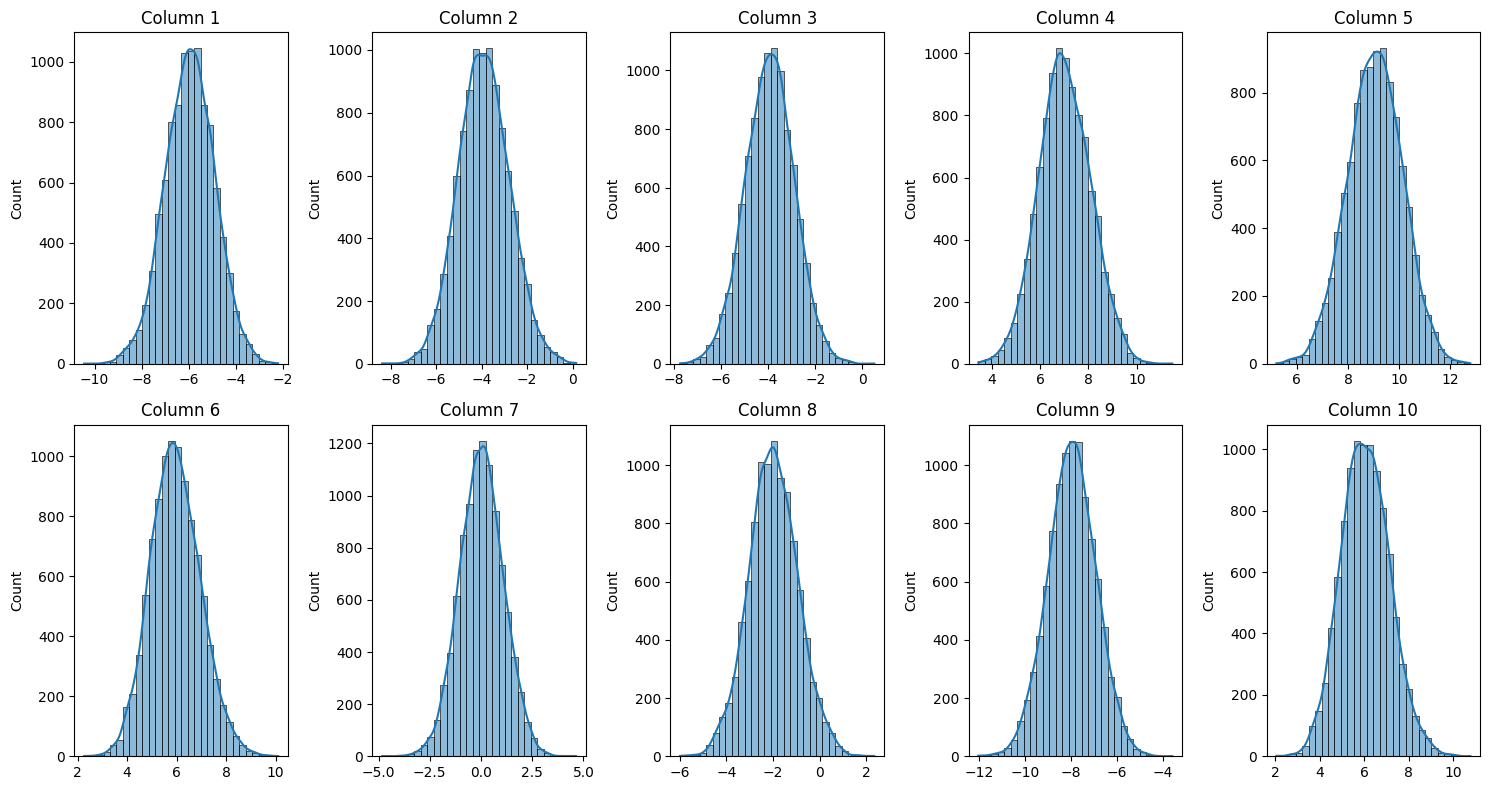

In [29]:
sampling_number = 10000
only_final = True
sample = process.sampling(sampling_number, only_final)
sample =sc.inverse_transform(sample.cpu().detach().numpy())
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i in range(10):
    sns.histplot(sample[:, i], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Column {i+1}') 


plt.tight_layout()

# Show the plot
plt.show()


In [30]:
sample = torch.tensor(sample).float().cuda()
print(discriminator(sample).mean())

tensor(0.9838, device='cuda:0', grad_fn=<MeanBackward0>)


In [3]:
import torch

data = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
q = 0.25  # 中位数
result = torch.quantile(data, q)
print(result)  # 输出: 3.0


tensor(2.)
